In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Tuple, List
import math

try:
    from scipy.stats import pearsonr
except Exception:  
    pearsonr = None  

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
def load_data(
    vacc_path: str = "../data/processed/cleaned_vaccination_data.csv",
    cases_path: str = "../data/processed/cleaned_case_data.csv",
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    vacc = pd.read_csv(vacc_path)
    cases = pd.read_csv(cases_path)
    if "Date_YMD" in cases.columns:
        cases["Date_YMD"] = pd.to_datetime(cases["Date_YMD"], dayfirst=True, errors="coerce")
    return vacc, cases

In [3]:
def plot_vaccination_coverage(vacc: pd.DataFrame, top_n: int = 10, bottom_n: int = 10) -> None:
    vacc_sorted = vacc.sort_values("vaccination_pct", ascending=False).reset_index(drop=True)

    plt.figure()
    plt.bar(vacc_sorted["State"].head(top_n), vacc_sorted["vaccination_pct"].head(top_n), color="#2a9d8f")
    plt.title(f"Top {top_n} by Vaccination Coverage (doses per 100 people)")
    plt.xlabel("State")
    plt.ylabel("Doses per 100")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.bar(vacc_sorted["State"].tail(bottom_n), vacc_sorted["vaccination_pct"].tail(bottom_n), color="#e76f51")
    plt.title(f"Bottom {bottom_n} by Vaccination Coverage (doses per 100 people)")
    plt.xlabel("State")
    plt.ylabel("Doses per 100")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    print("\nVaccination coverage preview (top 15):")
    print(vacc_sorted[["State", "Total Doses Administered", "Total 2021", "vaccination_pct"]].head(15))

    plt.figure(figsize=(10, max(6, len(vacc_sorted) * 0.3)))
    plt.barh(vacc_sorted["State"], vacc_sorted["vaccination_pct"], color="#4e79a7")
    plt.title("Vaccination Coverage by State (doses per 100 people)")
    plt.xlabel("Doses per 100")
    plt.ylabel("State")
    plt.tight_layout()
    plt.show()

In [4]:
def plot_state_timeseries(
    cases: pd.DataFrame,
    state_code: str,
    metrics: Iterable[str] = ("Confirmed", "Deceased", "Recovered"),
    ma: int = 7,
) -> None:
    colors = {"Confirmed": "#1f77b4", "Deceased": "#d62728", "Recovered": "#2ca02c"}

    any_plotted = False
    for metric in metrics:
        col = f"{state_code}_{metric}"
        if col not in cases.columns:
            continue
        df = cases[["Date_YMD", col]].dropna().sort_values("Date_YMD").copy()
        df[col + "_ma"] = df[col].rolling(ma, min_periods=1).mean()
        plt.plot(df["Date_YMD"], df[col + "_ma"], label=metric, color=colors.get(metric))
        any_plotted = True

    if any_plotted:
        plt.title(f"{state_code}: Daily (7-day MA)")
        plt.xlabel("Date")
        plt.ylabel("Count")
        plt.xticks(rotation=30, ha="right")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"No time-series columns found for state {state_code}.")


def plot_key_states_timeseries(cases: pd.DataFrame, states: Iterable[str]) -> None:
    for st in states:
        plt.figure()
        plot_state_timeseries(cases, st)


def _extract_state_codes(cases: pd.DataFrame, metric: str = "Confirmed") -> List[str]:
    codes = sorted({c.split("_")[0] for c in cases.columns if c.endswith(f"_{metric}")})
    return [c for c in codes if c != "TT"]


def plot_small_multiples_all_states(
    cases: pd.DataFrame,
    metric: str = "Confirmed",
    ma: int = 7,
    cols: int = 6,
    sharey: bool = False,
) -> None:
    states = _extract_state_codes(cases, metric=metric)
    if not states:
        print(f"No states/columns found for metric '{metric}'.")
        return

    rows = math.ceil(len(states) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 2.2), sharex=True, sharey=sharey)
    axes = np.atleast_2d(axes)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            if idx < len(states):
                st = states[idx]
                col = f"{st}_{metric}"
                df = cases[["Date_YMD", col]].dropna().sort_values("Date_YMD").copy()
                df[col + "_ma"] = df[col].rolling(ma, min_periods=1).mean()
                ax.plot(df["Date_YMD"], df[col + "_ma"], color="#1f77b4", linewidth=1)
                ax.set_title(st, fontsize=9)
                ax.tick_params(axis='x', labelrotation=30, labelsize=7)
                ax.tick_params(axis='y', labelsize=7)
            else:
                ax.axis('off')
            idx += 1

    fig.suptitle(f"All States: {metric} (7-day MA)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

In [5]:
def build_cases_summary(cases: pd.DataFrame) -> pd.DataFrame:
    confirmed_cols = [c for c in cases.columns if c.endswith("_Confirmed")]
    deceased_cols = [c for c in cases.columns if c.endswith("_Deceased")]

    confirmed_totals = cases[confirmed_cols].sum(axis=0)
    deceased_totals = cases[deceased_cols].sum(axis=0)

    return pd.DataFrame({
        "State": [c.split("_")[0] for c in confirmed_totals.index],
        "Total_Confirmed": confirmed_totals.values,
        "Total_Deaths": deceased_totals.values,
    })


def scatter_vacc_vs_outcomes(merged: pd.DataFrame) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].scatter(merged["vaccination_pct"], merged["Total_Confirmed"], alpha=0.8)
    axes[0].set_title("Vaccination vs Total Confirmed")
    axes[0].set_xlabel("Doses per 100 people")
    axes[0].set_ylabel("Total Confirmed")

    axes[1].scatter(merged["vaccination_pct"], merged["Total_Deaths"], color="#d62728", alpha=0.8)
    axes[1].set_title("Vaccination vs Total Deaths")
    axes[1].set_xlabel("Doses per 100 people")
    axes[1].set_ylabel("Total Deaths")

    for st in ["MH", "UP", "DL", "KA"]:
        row = merged[merged["State"] == st]
        if not row.empty:
            x, y = row["vaccination_pct"].values[0], row["Total_Confirmed"].values[0]
            axes[0].scatter(x, y, color="orange")
            axes[0].text(x, y, st, fontsize=9, ha="left", va="bottom")

    plt.tight_layout()
    plt.show()


def print_correlations(merged: pd.DataFrame) -> None:
    cols = ["vaccination_pct", "Total_Confirmed", "Total_Deaths"]
    corr_mat = merged[cols].corr(method="pearson")
    print("Correlation Matrix (Pearson):\n", corr_mat, "\n")

    if pearsonr is not None:
        r1 = pearsonr(merged["vaccination_pct"], merged["Total_Confirmed"])
        r2 = pearsonr(merged["vaccination_pct"], merged["Total_Deaths"])
        print(f"Pearson r (vaccination_pct vs Total_Confirmed): r={r1[0]:.3f}, p={r1[1]:.3g}")
        print(f"Pearson r (vaccination_pct vs Total_Deaths):    r={r2[0]:.3f}, p={r2[1]:.3g}")
    else:
        r1 = np.corrcoef(merged["vaccination_pct"], merged["Total_Confirmed"])[0, 1]
        r2 = np.corrcoef(merged["vaccination_pct"], merged["Total_Deaths"])[0, 1]
        print(f"Pearson r (vaccination_pct vs Total_Confirmed): r={r1:.3f} (p=N/A)")
        print(f"Pearson r (vaccination_pct vs Total_Deaths):    r={r2:.3f} (p=N/A)")

In [6]:
vacc, cases = load_data()

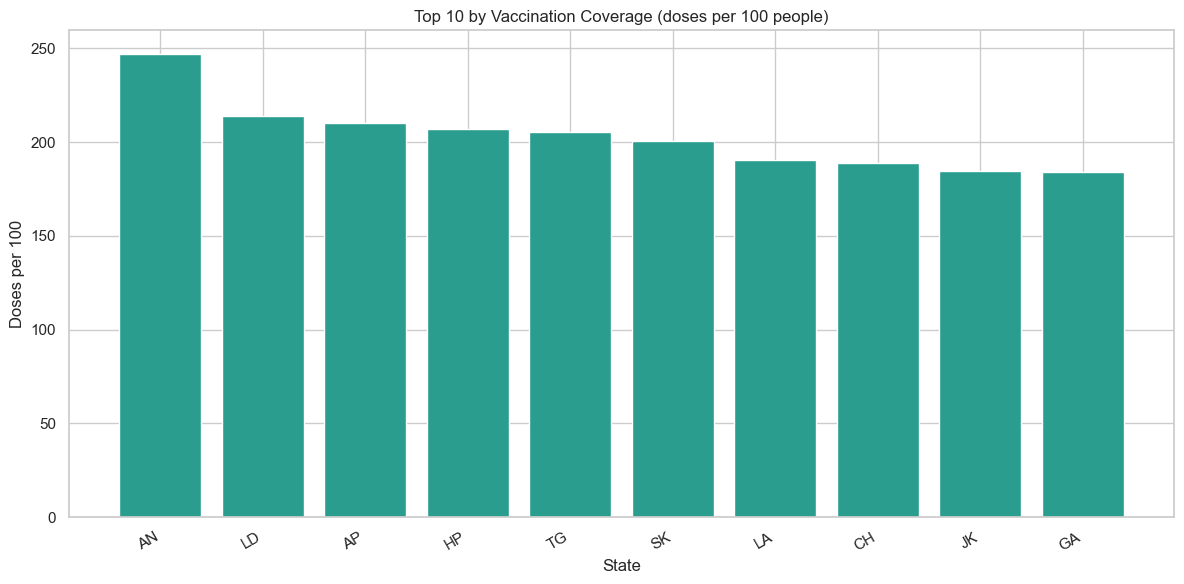

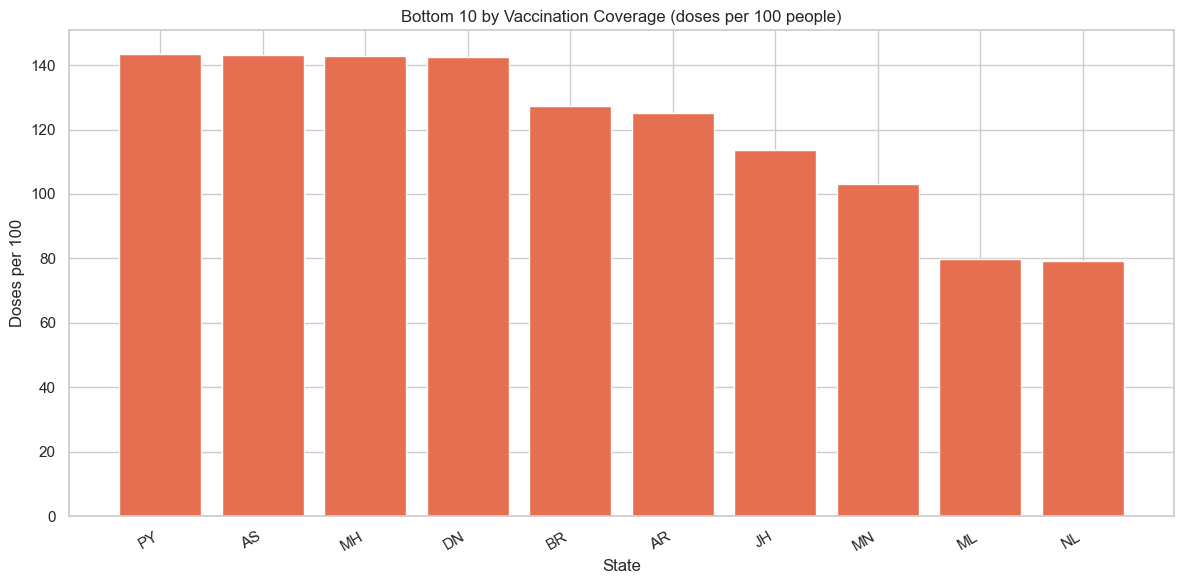


Vaccination coverage preview (top 15):
   State  Total Doses Administered  Total 2021  vaccination_pct
0     AN                    991264      401000       247.198005
1     LD                    145313       68000       213.695588
2     AP                 110957429    52849000       209.951804
3     HP                  15325484     7406000       206.933351
4     TG                  77625266    37771000       205.515517
5     SK                   1360477      678000       200.660324
6     LA                    567133      298000       190.313087
7     CH                   2291777     1212000       189.090512
8     JK                  24782265    13440000       184.391853
9     GA                   2874477     1561000       184.143306
10    GJ                 128105428    70075000       182.811884
11    KA                 122152256    66986000       182.354904
12    DL                  37409264    20703000       180.694894
13    OR                  81545960    45793000       178.075164


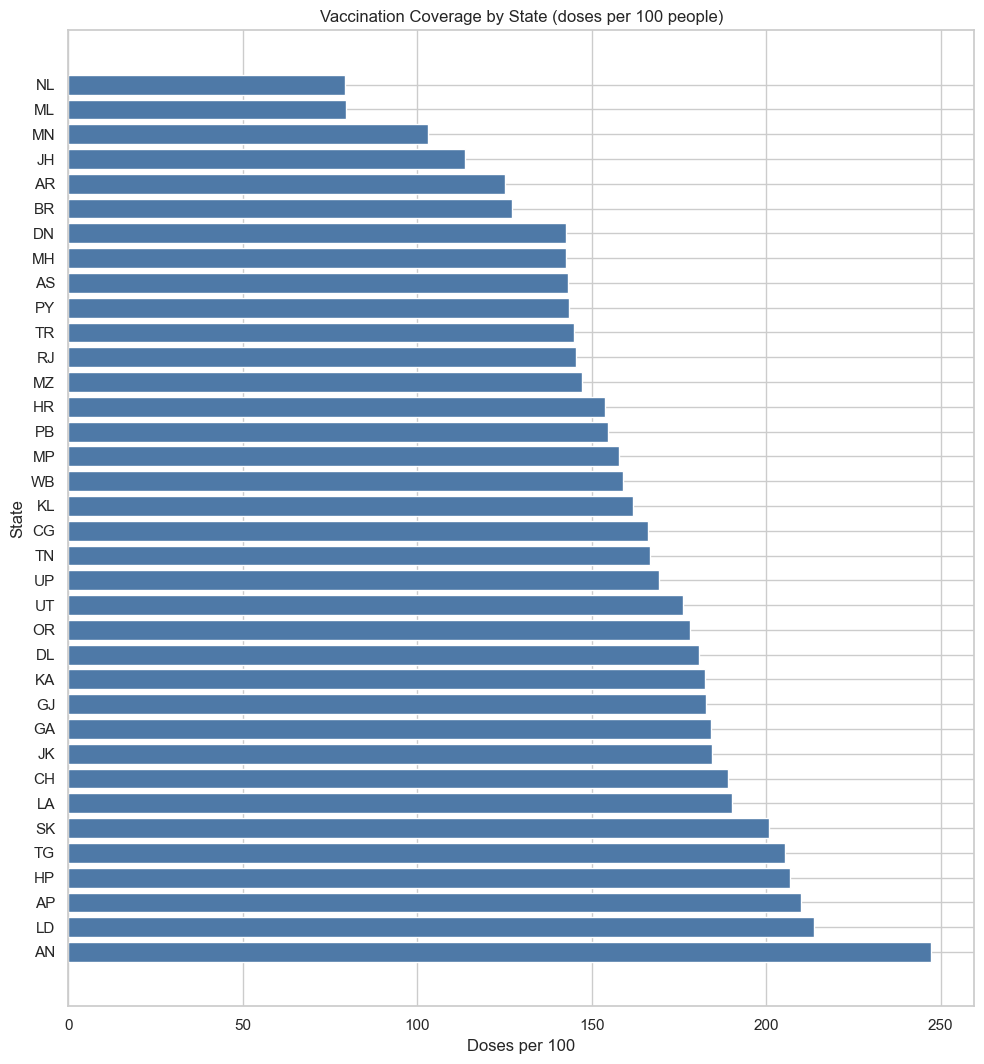

In [7]:
plot_vaccination_coverage(vacc, top_n=10, bottom_n=10)

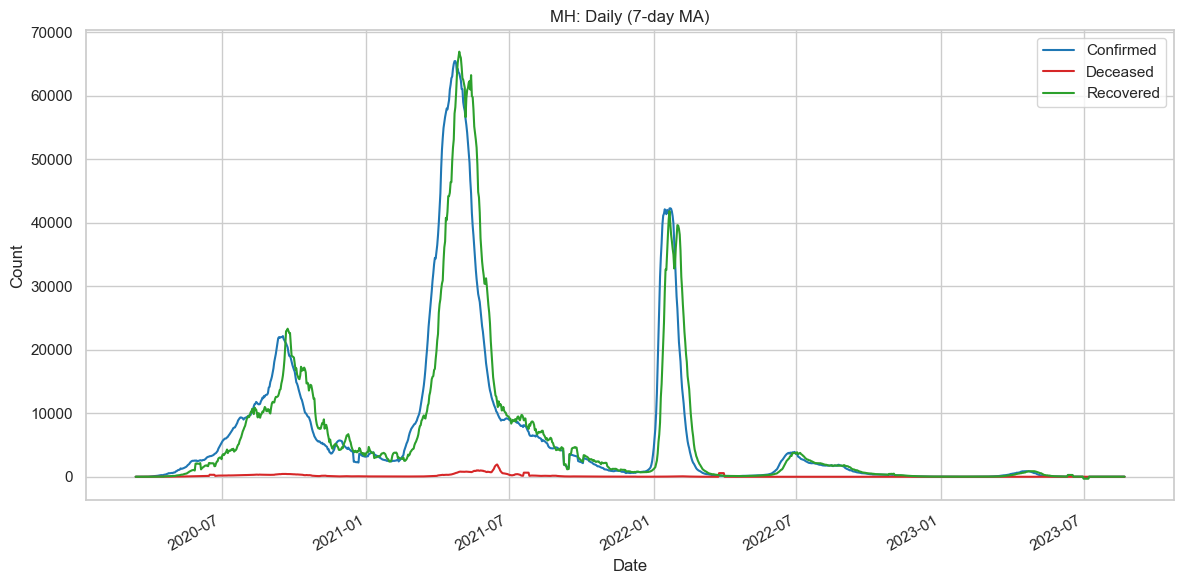

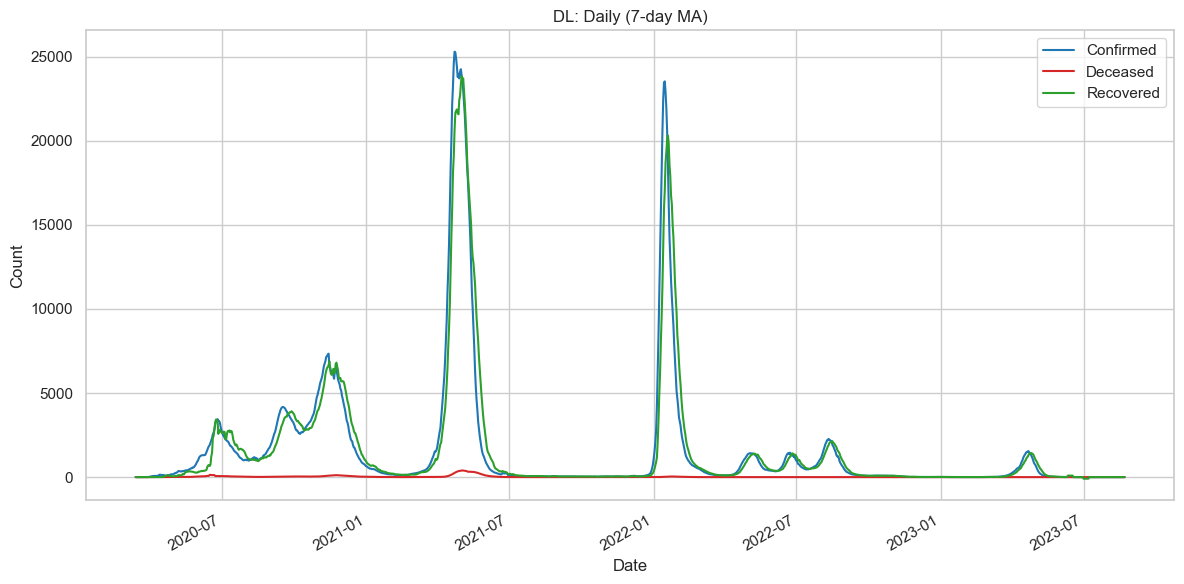

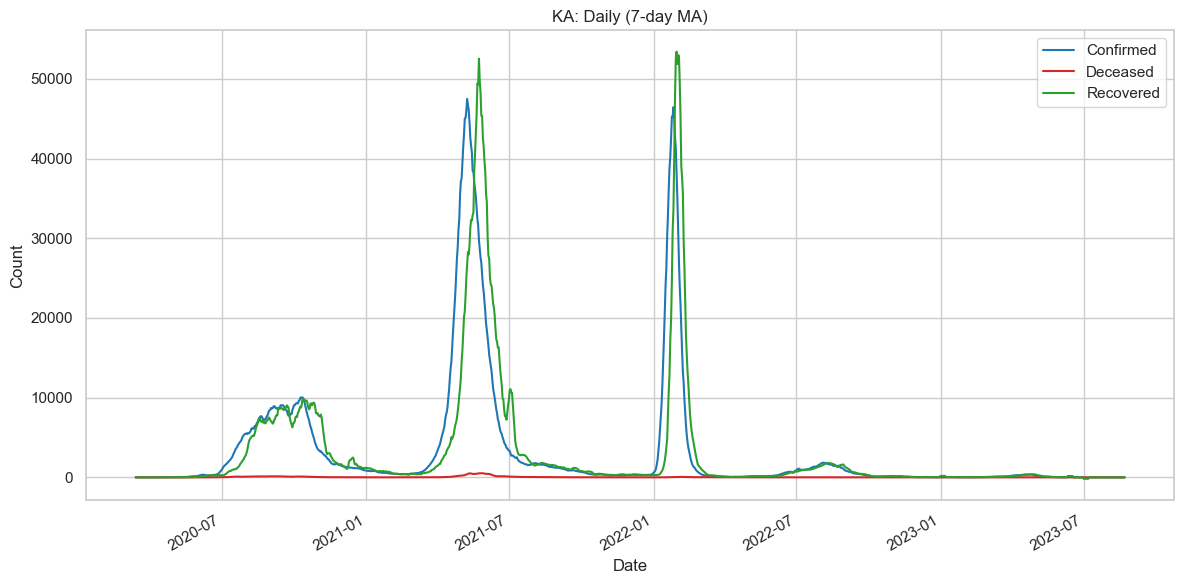

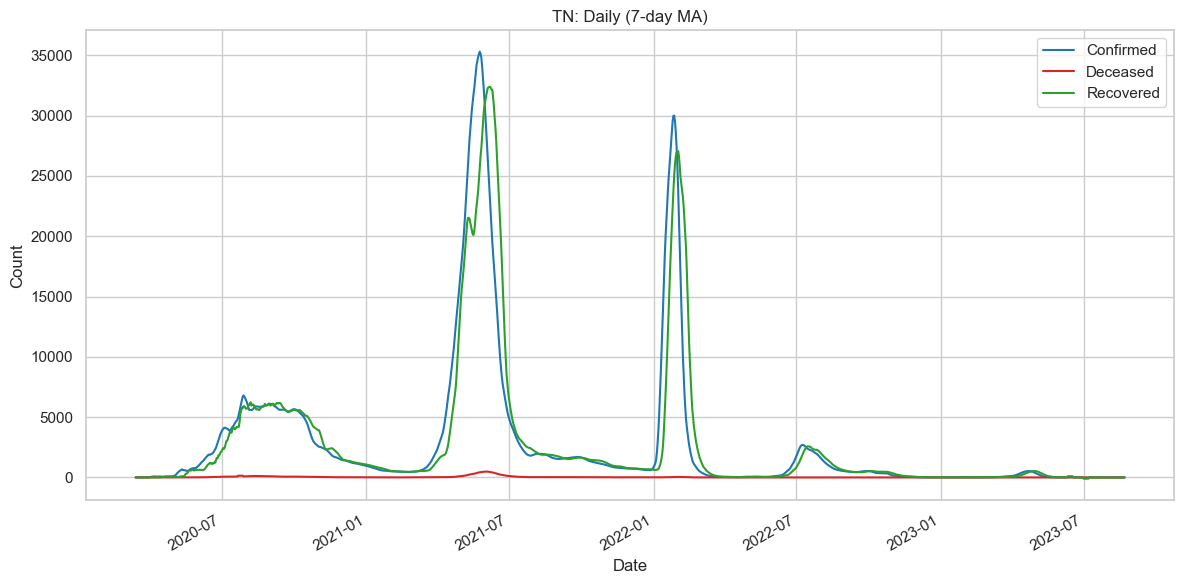

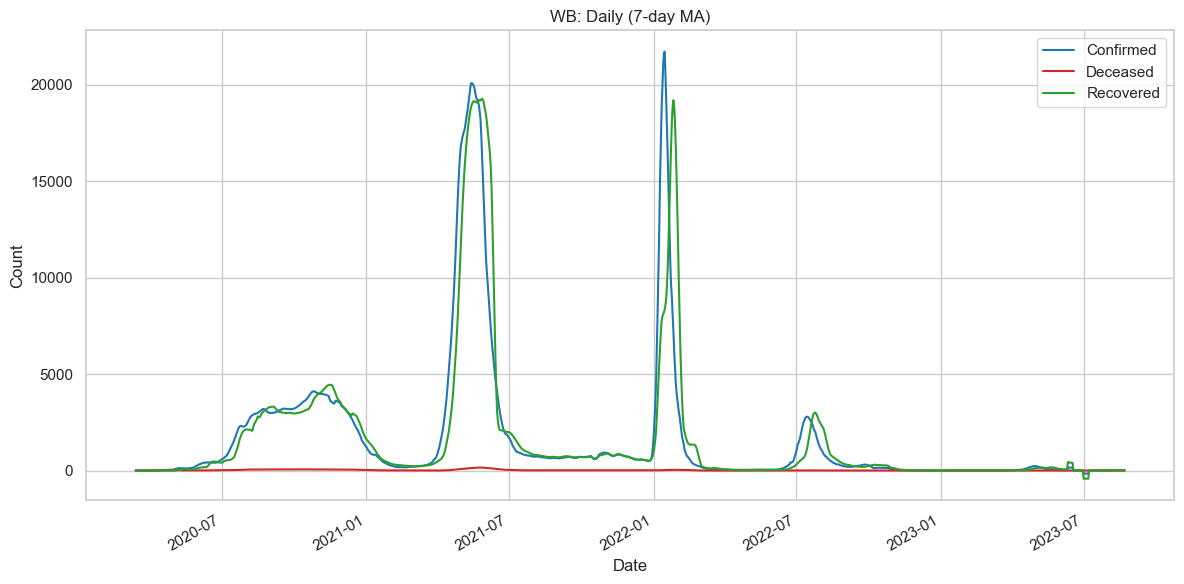

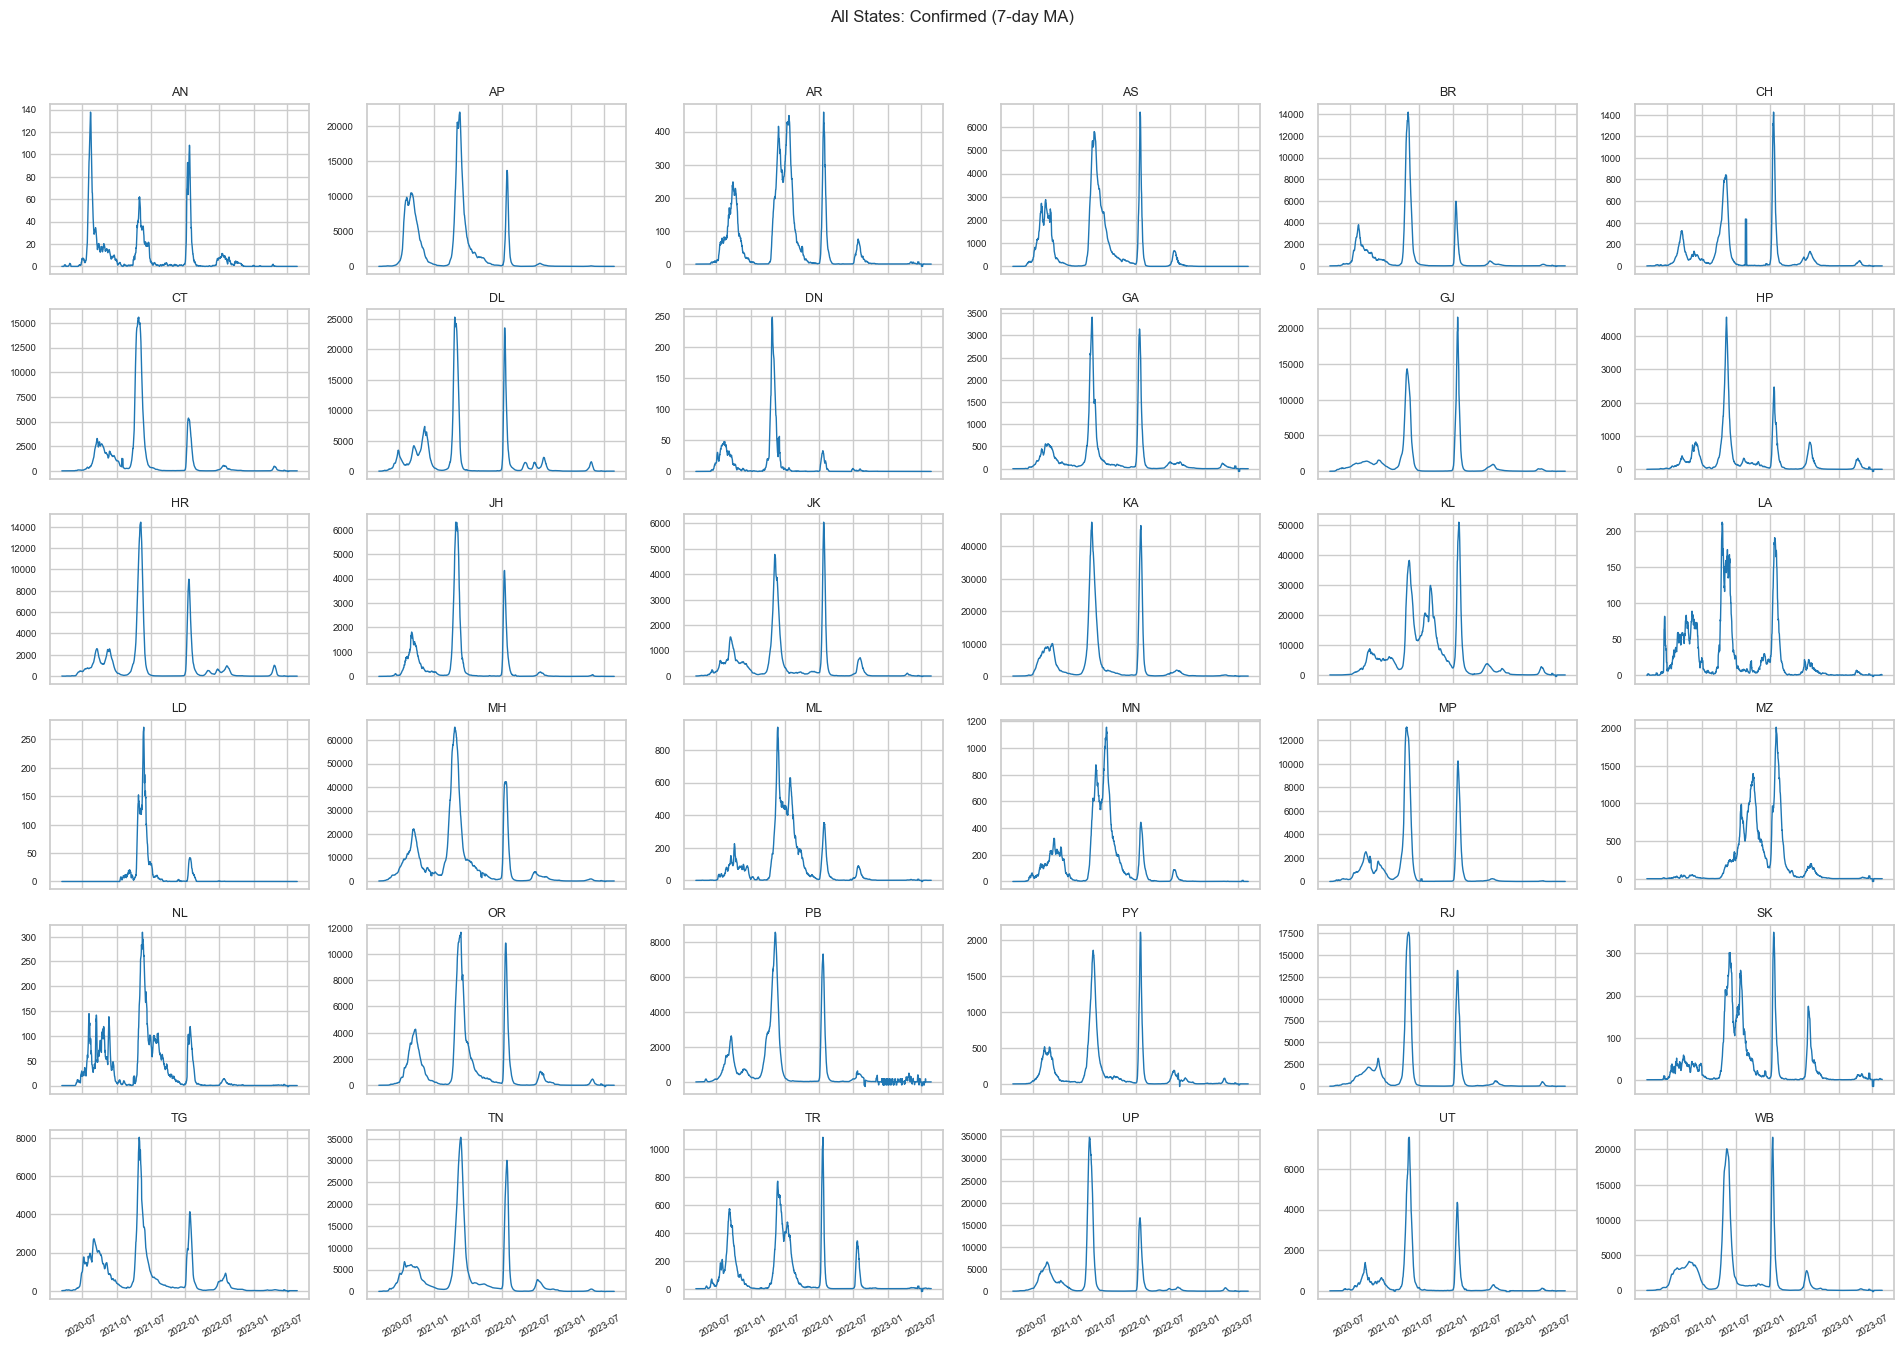

In [8]:
plot_key_states_timeseries(cases, states=["MH", "DL", "KA", "TN", "WB"])
plot_small_multiples_all_states(cases, metric="Confirmed", ma=7, cols=6, sharey=False)

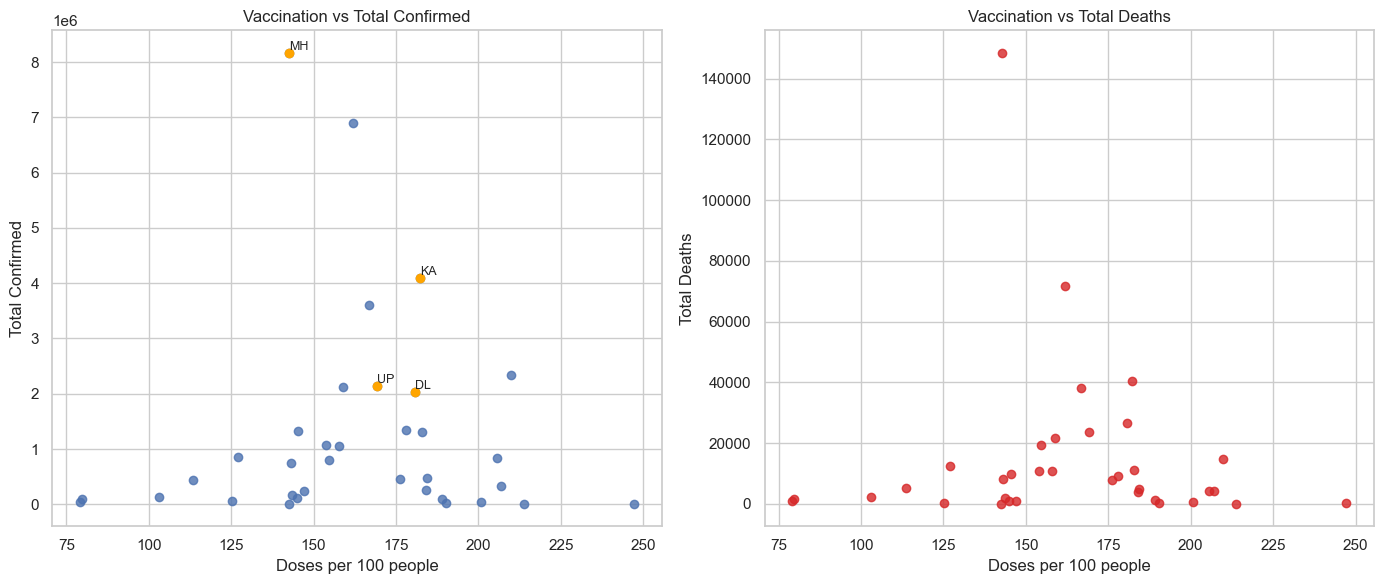

Correlation Matrix (Pearson):
                  vaccination_pct  Total_Confirmed  Total_Deaths
vaccination_pct         1.000000         0.027783     -0.041974
Total_Confirmed         0.027783         1.000000      0.944388
Total_Deaths           -0.041974         0.944388      1.000000 

Pearson r (vaccination_pct vs Total_Confirmed): r=0.028, p=0.874
Pearson r (vaccination_pct vs Total_Deaths):    r=-0.042, p=0.811


In [9]:
cases_summary = build_cases_summary(cases)
merged = pd.merge(vacc[["State", "vaccination_pct"]], cases_summary, on="State", how="inner")
scatter_vacc_vs_outcomes(merged)
print_correlations(merged)

In [10]:
import statsmodels.api as sm
df = merged.copy()
df = df.dropna(subset=["vaccination_pct", "Total_Confirmed", "Total_Deaths"])
X = df[["vaccination_pct", "Total_Confirmed"]]
X = sm.add_constant(X)
y = df["Total_Deaths"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Total_Deaths   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     138.6
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           1.73e-16
Time:                        11:41:22   Log-Likelihood:                -367.36
No. Observations:                  35   AIC:                             740.7
Df Residuals:                      32   BIC:                             745.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5633.1448   7142.285     